## Introduction

- This lecture presents generalized least-squares (GLS) estimation in the linear regression model.
- GLS estimators are appropriate when one or more of the assumptions of homoskedasticity and noncorrelation of regression errors fails.

## Modeling heteroskedastic data

- Heteroskedastic errors are pervasive in microeconometrics.
- The failure of homoskedasticity in the standard regression model leads to the OLS estimator being inefficient, though it is still a consistant estimator.

- Given heteroskedastic errors, there are two leading approaches:
    + The first is to obtain robust estimates of the standard errors of regression coefficients without assumptions about the functional form of heteroskedasticity.
    + The second apporach seeks to model the heteroskedasticity and to obtain more-efficient FGLS estimates.

### Simulated dataset

- The specific data-generating process (DGP) is $$ \begin{matrix}
y & = & 1+x_2+x_3+u; \; x_2,x_3\sim N(0,25) \\
u & = & \sqrt{exp(-1+0.2x_2)}\times\varepsilon; \; \varepsilon\sim N(0,25)
\end{matrix} $$
- We generate a sample of size 500 from this DGP

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [3]:
from scipy import stats
np.random.seed(10101)
N=500
nd=stats.norm(0,5)
x2,x3,epsilon=np.split(nd.rvs(3*N),3)
u=np.sqrt(np.exp(-1+0.2*x2))*epsilon
y=1+x2+x3+u
data=pd.DataFrame({'x2':x2,'x3':x3,'e':epsilon,'u':u,'y':y})
data.describe([])

,x2,x3,e,u,y
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.105675,-0.001212,0.095266,0.072774,1.177237
std,5.103832,5.000587,4.896203,3.506734,7.911386
min,-16.113826,-15.801241,-14.490510,-13.406188,-23.120749
50%,0.021711,-0.022021,0.059194,0.019839,1.065032
max,17.840012,16.877893,15.768188,15.375412,31.524742


### OLS estimation

- OLS regression with default standard errors yields

In [4]:
res=smf.ols(formula='y~x2+x3',data=data).fit()
res.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0715,0.157,6.827,0.000,0.763,1.380
x2,1.0121,0.031,32.886,0.000,0.952,1.073
x3,0.9638,0.031,30.685,0.000,0.902,1.026


- The standard procedure is to obtain heteroskedasticity-robust standard errors for the same OLS estimators.

In [5]:
res1=smf.ols(formula='y~x2+x3',data=data).fit(cov_type='HC1')
res1.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.0715,0.154,6.938,0.000,0.769,1.374
x2,1.0121,0.039,26.100,0.000,0.936,1.088
x3,0.9638,0.032,30.315,0.000,0.902,1.026


### Detecting heteroskedasticity

- A simple informal diagnostic procedure is to plot the absolute value of the fitted regression residual, $|\hat{u}_i|$, against a variable assumed to be in the skedasticity function.

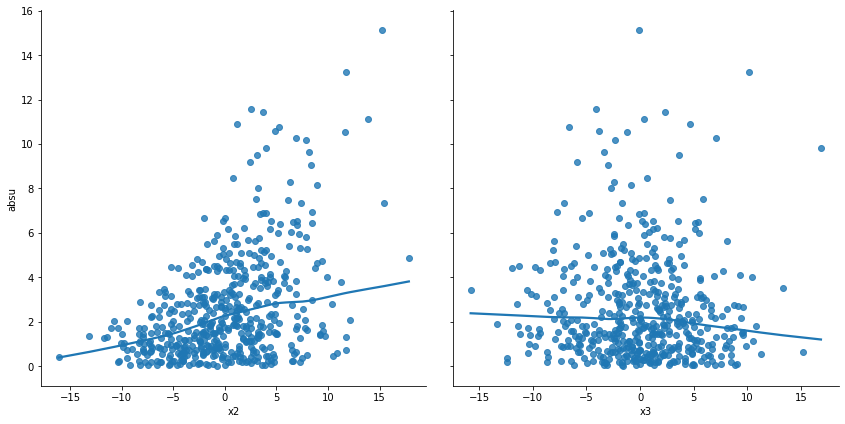

In [6]:
data['absu']=np.abs(res.resid)
g=sns.PairGrid(data,y_vars='absu',x_vars=['x2','x3'],height=6)
g.map(sns.regplot, lowess=True)
plt.show()

- We can also go beyond a visual representation of heteroskedasticity by formally testing the null hypothesis of homoskedasticity against the alternative that residual variances depend upon some or all regressors. (Breusch–Pagan test)

In [7]:
from statsmodels.stats.diagnostic import het_breuschpagan

exog=pd.DataFrame(res.model.exog,columns=['const','x2','x3'])
print(het_breuschpagan(res.resid, exog[['const','x2']])[1])
print(het_breuschpagan(res.resid, exog[['const','x3']])[1])
print(het_breuschpagan(res.resid, exog)[1])

1.1971463661571842e-18
0.8929714690971295
1.3367559351625431e-17


### FGLS estimation

- For potential gains in efficiency, we can estimate the parameters of the model by using the two-step FGLS estimation method.
- At the first step, we estimate the linear regression by OLS, save the residuals $\hat{u}_i = y-x'\hat{\beta}_{OLS}$, estimate the skedasticity function $\sigma^2(z_i, \gamma)$ by regressing $\hat{u}_i^2$ on $\sigma^2(z_i, \gamma)$, and get the predicted values $\hat{\sigma}^2(z_i, \hat{\gamma})$. 

- Here our tests suggest that the skedasticity function should include only x2. 
- We specify the skedasticity function $\sigma^2(z) = \exp(\gamma_1 + \gamma_2 x_2)$, because taking the exponential ensures a positive variance.

In [8]:
from scipy.optimize import least_squares

def func(g,x,y):
    return np.exp(g[0]+g[1]*x)-y

data['uhatsq']=res.resid**2
g0=np.ones(2)
res_lsq = least_squares(func, g0, args=(data.x2, data.uhatsq))
data['varu']=np.exp(res_lsq.x@[np.ones(len(data.x2)),data.x2])

- At the second step, the predictions $\hat{\sigma}^2(z)$ define the weights that are used to obtain the FGLS estimator. 
- Specifically, we regress $y_i/\hat{\sigma}_i$ on $x_i/\hat{\sigma}_i$ where $\hat{\sigma}_i^2 = \exp(\hat{\gamma}_1+\hat{\gamma}_2 x_{2i})$.

In [9]:
res2=smf.wls(formula='y~x2+x3',data=data,weights=1./data.varu).fit()
res2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0664,0.144,7.415,0.000,0.784,1.349
x2,1.0065,0.024,41.193,0.000,0.959,1.055
x3,0.9839,0.023,42.090,0.000,0.938,1.030


### WLS estimation

- The FGLS standard errors are based on the assumption of a correct model for heteroskedasticity.
- To guard against misspecification of this model, we use the WLS estimator, which is equal to the FGLS estimator but uses robust standard errors that do not rely on a model for heteroskedasticity.

In [10]:
res3=smf.wls(formula='y~x2+x3',data=data,weights=1./data.varu).fit(cov_type='HC1')
res3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,1.0664,0.148,7.194,0.000,0.776,1.357
x2,1.0065,0.023,43.982,0.000,0.962,1.051
x3,0.9839,0.021,46.588,0.000,0.942,1.025


## System of linear regressions

- In this section, we extend GLS estimation to a system of linear equations with errors that are correlated across equations for a given individual but are uncorrelated across individuals. 
- Then cross-equation correlation of the errors can be exploited to improve estimator efficiency. 
- This multivariate linear regression model is usually referred to in econometrics as a set of SUR equations.

### Application to two categories of expenditures

- The application of SUR considered here involves two dependent variables that are the logarithm of expenditure on prescribed drugs (ldrugexp) and expenditure on all categories of medical services other than drugs (ltotothr).
- This data extract from the Medical Expenditure Panel Survey (MEPS) is similar to that studied in the previous chapter and covers the Medicare-eligible population of those aged 65 years and more.

In [11]:
data=pd.read_stata('data/mus05surdata.dta')
data[['ldrugexp','ltotothr','age','age2','educyr','actlim','totchr','medicaid','private']].describe([])

,ldrugexp,ltotothr,age,age2,educyr,actlim,totchr,medicaid,private
count,3285.000000,3350.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000,3384.000000
mean,6.936536,7.537203,74.384752,5573.835938,11.291076,0.345449,1.954492,0.161643,0.515662
std,1.300313,1.612980,6.388984,961.357056,3.775800,0.475585,1.326529,0.368177,0.499829
min,1.386294,1.098612,65.000000,4225.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.155396,7.508513,74.000000,5476.000000,12.000000,0.000000,2.000000,0.000000,1.000000
max,10.337734,11.718923,90.000000,8100.000000,17.000000,1.000000,8.000000,1.000000,1.000000


- Because SUR estimation reduces to OLS if exactly the same set of regressors appears in each equation, we omit educyr from the model for ldrugexp, and we omit medicaid from the model for ltotothr.

In [12]:
from linearmodels.system import SUR

formula = '{ldrugexp ~ 1 + age+age2+actlim+totchr+medicaid+private} {ltotothr ~ 1 + age+age2+educyr+actlim+totchr+private}'
res = SUR.from_formula(formula, data).fit(cov_type='unadjusted')
print('\n'.join(res.summary.as_text().split('\n')[8:]))

                                                                              
               Equation: ldrugexp, Dependent Variable: ldrugexp               
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -3.8913     2.9759    -1.3076     0.1910     -9.7239      1.9414
age            0.2630     0.0795     3.3074     0.0009      0.1072      0.4189
age2          -0.0017     0.0005    -3.2964     0.0010     -0.0028     -0.0007
actlim         0.3547     0.0466     7.6079     0.0000      0.2633      0.4460
totchr         0.4005     0.0161     24.810     0.0000      0.3689      0.4322
medicaid       0.1068     0.0592     1.8028     0.0714     -0.0093      0.2229
private        0.0810     0.0436     1.8598     0.0629     -0.0044      0.1664
               Equation: ltotothr, Dependent Variable: ltotothr               
            Parameter  Std. Err.     T-stat    P-val

C:\Users\bayes\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


- We yields the correlation matrix for the fitted residuals that is used to form a test of the independence of the errors in the two equations.

In [13]:
cov = res.sigma
std = np.sqrt(np.diag(res.sigma)[:,None])
corr = pd.DataFrame(cov / (std @ std.T),columns=['ldrugexp','ltotothr'],index=['ldrugexp','ltotothr'])
corr.style.format('{:0.3f}')

,ldrugexp,ltotothr
ldrugexp,1.000,0.174
ltotothr,0.174,1.000


- The standard errors reported impose homoskedasticity. 
- This is a reasonable assumption in this example, because taking the natural logarithm of expenditures greatly reduces heteroskedasticity.
- But in other applications, such as using the levels of expenditures, this would not be reasonable.

In [14]:
res = SUR.from_formula(formula, data).fit(cov_type='robust')
print('\n'.join(res.summary.as_text().split('\n')[8:]))

                                                                              
               Equation: ldrugexp, Dependent Variable: ldrugexp               
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -3.8913     2.6290    -1.4802     0.1388     -9.0439      1.2614
age            0.2630     0.0702     3.7478     0.0002      0.1255      0.4006
age2          -0.0017     0.0005    -3.7387     0.0002     -0.0027     -0.0008
actlim         0.3547     0.0400     8.8715     0.0000      0.2763      0.4330
totchr         0.4005     0.0144     27.828     0.0000      0.3723      0.4287
medicaid       0.1068     0.0539     1.9798     0.0477      0.0011      0.2125
private        0.0810     0.0390     2.0788     0.0376      0.0046      0.1574
               Equation: ltotothr, Dependent Variable: ltotothr               
            Parameter  Std. Err.     T-stat    P-val

C:\Users\bayes\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


### Imposing cross-equation constraints

- We now obtain estimates that impose restrictions on parameters across equations. 
- Usually, such constraints are based on economic theory. 
- As an illustrative example, we impose the constraint that having private insurance has the same impact on both dependent variables.

In [15]:
mod=SUR.from_formula(formula, data)
r = pd.DataFrame(np.zeros((1,len(mod.param_names))),columns=mod.param_names)
r['ldrugexp_private']=-1
r['ltotothr_private']=1
r

,ldrugexp_Intercept,ldrugexp_age,ldrugexp_age2,ldrugexp_actlim,ldrugexp_totchr,ldrugexp_medicaid,ldrugexp_private,ltotothr_Intercept,ltotothr_age,ltotothr_age2,ltotothr_educyr,ltotothr_actlim,ltotothr_totchr,ltotothr_private
0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0,0.0,0.0,1


In [16]:
mod.add_constraints(r)
res = mod.fit()
print('\n'.join(res.summary.as_text().split('\n')[8:]))

                                                                              
               Equation: ldrugexp, Dependent Variable: ldrugexp               
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -4.2351     2.6284    -1.6113     0.1071     -9.3867      0.9165
age            0.2707     0.0702     3.8568     0.0001      0.1331      0.4083
age2          -0.0018     0.0005    -3.8408     0.0001     -0.0027     -0.0009
actlim         0.3575     0.0400     8.9392     0.0000      0.2791      0.4359
totchr         0.3998     0.0144     27.760     0.0000      0.3716      0.4280
medicaid       0.1474     0.0519     2.8396     0.0045      0.0457      0.2491
private        0.1483     0.0284     5.2281     0.0000      0.0927      0.2039
               Equation: ltotothr, Dependent Variable: ltotothr               
            Parameter  Std. Err.     T-stat    P-val

## Survey data: Weighting, clustering, and stratification

- We now turn to a quite different topic: adjustments to standard estimation methods when the data are not from a simple random sample, as we have implicitly assumed, but instead come from complex survey data.
- Complex survey data lead to a sample that can be weighted, clustered, and stratified.

- As an example of complex survey data, we use `nhanes2.dta`. 
- These data come from the second National Health and Nutrition Examination Survey (NHANES II), a U.S. survey conducted in 1976-1980.
- We consider models for the hemoglobin count, a measure of the amount of the oxygen-transporting protein hemoglobin present in one's blood.
- We estimate both the mean and the relationship with age and gender, restricting analysis to nonelderly adults.

- Here is a brief explanation of the survey design for the data analyzed: 
    + The country is split into 32 geographical strata. 
    + Each stratum contains a number of primary sampling units (PSUs), where a PSU represents a county or several contiguous counties with an average population of several hundred thousand people. 
    + Exactly two PSUs were chosen from each of the 32 strata, and then several hundred individuals were sampled from each PSU. 

- We can see descriptions and summary statistics for the key survey design variables and key analysis variables by typing

In [17]:
data=pd.read_stata('data/mus05nhanes2.dta')
data=data.loc[(data.age>=21) & (data.age<=65),:]
data.loc[:,['sampl','finalwgt','strata','psu']].describe([])

,sampl,finalwgt,strata,psu
count,8136.000000,8136.000000,8136.000000,8136.000000
mean,33518.937930,12654.808997,16.671460,1.487955
std,18447.036657,7400.204525,9.431087,0.499886
min,1400.000000,2079.000000,1.000000,1.000000
50%,34516.000000,10923.500000,16.000000,1.000000
max,64702.000000,79634.000000,32.000000,2.000000


In [18]:
t=data.groupby(['strata','psu']).agg({'sampl':'count'})
t.groupby(['strata']).agg({'sampl':['count','sum','min','mean','max']})

sampl                      
       count  sum  min   mean  max
strata                            
1          2  286  132  143.0  154
2          2  138   57   69.0   81
3          2  255  103  127.5  152
4          2  369  179  184.5  190
5          2  215   93  107.5  122
6          2  245  112  122.5  133
7          2  349  145  174.5  204
8          2  250  114  125.0  136
9          2  203   88  101.5  115
10         2  205   97  102.5  108
11         2  226  105  113.0  121
12         2  253  123  126.5  130
13         2  276  121  138.0  155
14         2  327  163  163.5  164
15         2  295  145  147.5  150
16         2  268  128  134.0  140
17         2  321  142  160.5  179
18         2  287  117  143.5  170
20         2  221   95  110.5  126
21         2  170   84   85.0   86
22         2  242   98  121.0  144
23         2  277  136  138.5  141
24         2  339  162  169.5  177
25         2  210   94  105.0  116
26         2  210  103  105.0  107
27         2  230  110  115.0  120
28         2  229  106  114.5  123
29         2  351  165  175.5  186
30         2  291  134  145.5  157
31         2  251  115  125.5  136
32         2  347  166  173.5  181

### Survey mean estimation

- We consider estimation of the population mean of `hgb`, the hemoglobin count with a normal range of approximately 12-15 for women and 13.5-16.5 for men. 
- To estimate the population mean, we should definitely use the sampling weights.

In [19]:
np.average(data.hgb,weights=data.finalwgt)

14.297127459497771

In [20]:
np.average(data.hgb)

14.285755

### Survey linear regression

- The same weighted estimates, with standard errors that control for clustering can be obtained

In [21]:
data.loc[:,'uniqpsu']=2*data.strata+data.psu
res=smf.wls(formula='hgb~age+female',data=data,weights=data.finalwgt).fit(cov_type='cluster',cov_kwds={'groups': data.uniqpsu})
res.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,15.0851,0.065,230.648,0.000,14.957,15.213
age,0.0022,0.001,1.947,0.052,-1.44e-05,0.004
female,-1.6968,0.032,-53.367,0.000,-1.759,-1.635


- Finally, consider a naive OLS regression without weighting or obtaining cluster robust VCE

In [22]:
res2=smf.ols(formula='hgb~age+female',data=data).fit()
res2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.0712,0.041,370.975,0.000,14.992,15.151
age,0.0013,0.001,1.579,0.114,-0.000,0.003
female,-1.6242,0.025,-65.340,0.000,-1.673,-1.575
